## 神经网络中的激活函数

---

| 名称 | 中译 | PyTorch 类 | 定义 | 优势 |
|---|---|---|---|---|
| **ReLU (Rectified Linear Unit)** | 修正线性单元 | `torch.nn.ReLU` | $ f(x)=max(0, x) $ | * 计算效率高<br> * 缓解梯度消失问题（在正区间）<br> * 在很多情况下表现良好 |
| **Sigmoid** | Sigmoid 函数 (S 型函数) | `torch.nn.Sigmoid` | $ f(x)=\frac{1}{1+e^{-x}} $ | * 输出范围在 0 到 1 之间，可以解释为概率<br> * 在二分类问题中常用 |
| **Tanh (Hyperbolic Tangent)** | 双曲正切函数 | `torch.nn.Tanh` | $ f(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}} $ | * 输出范围在 -1 到 1 之间，均值为 0<br> * 有时比 Sigmoid 收敛更快 |
| **LeakyReLU** | 带泄露修正线性单元 | `torch.nn.LeakyReLU` | $ f(x) = \begin{cases} x, & \text{for } x > 0 \\ \alpha x, & \text{for } x \leq 0 \end{cases} $ | * 解决了 ReLU 的“死亡 ReLU”问题<br> * 在负区间有小的非零梯度 |
| **Softmax** | Softmax 函数 | `torch.nn.Softmax` | $ f(x_i)=\frac{e^{x_i}}{\sum_{j=1}^{K}e^{x_j}} $ | * 将输出转换为概率分布<br> * 通常用于多分类问题的输出层 |
| **Softplus** | Softplus 函数 | `torch.nn.Softplus` | $ f(x)=\ln(1 + e^x) $ | * ReLU 的平滑版本<br> * 处处可导 |
| **ELU (Exponential Linear Unit)** | 指数线性单元 | `torch.nn.ELU` | $ f(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha (e^x - 1) & \text{otherwise} \end{cases} $ | * 解决了 ReLU 的“死亡 ReLU”问题<br> * 输出的均值接近于零，加速收敛 |
| **PReLU (Parametric ReLU)** | 参数化修正线性单元 | `torch.nn.PReLU` | $ f(x) = \begin{cases} x, & \text{for } x > 0 \\ \alpha x, & \text{for } x \leq 0 \end{cases} $ | * LeakyReLU 的改进版本，负区间的斜率是可学习的参数<br> * 适应性更强 |
| **GELU (Gaussian Error Linear Unit)** | 高斯误差线性单元 | `torch.nn.GELU` | $ f(x) = x \cdot \frac{1}{2} \left[ 1 + \text{erf} \left( \frac{x}{\sqrt{2}} \right) \right] $ |   *   在 Transformer 模型中常用<br>    *   性能通常优于 ReLU 和 ELU |

In [1]:
import torch
import pandas
import numpy
import IPython.display
import matplotlib.pyplot

matplotlib.pyplot.style.use('matplotlib.mplstyle')

# 设置 GPU
DEVICE0, DEVICE1 = torch.device('cuda:0'), torch.device('cuda:1')

### 仿射变换

仿射变换（Affine transformation），简单来说，就是在几何中，对一个向量空间进行一次线性变换并加上一个平移的变换。更详细地解释：

* 是线性变换（如旋转、缩放）与平移的组合。
* 数学公式：$ Y = WX + B $，其中 $ W $ 为线性变换矩阵，$ B $ 为平移向量。
* 特性：保持直线、平行线，但不一定保持距离、角度。
* 应用：广泛用于计算机图形学、图像处理、机器学习和机器人学中的坐标转换。

需要注意的是，$ WX $ 表达式使用的是矩阵乘法，如果 $ W $ 为列向量（列矩阵），那么 $ W \times B = W \cdot B $

将仿射变换应用于神经网络前向传播，是随着神经网络的发展而自然产生的。

在深度学习领域，有一篇名为 [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025) 的论文，深入地探讨和应用了仿射变换在神经网络中的作用，值得一提，这篇论文由 DeepMind 的 Max Jaderberg 等人于 2015 年发表。

这里可以这么理解，对于线性函数而言，有一个特性就是线性函数与线性函数的叠加，无论多少层，最终的结果仍然是线性函数，它并不能计算非线性特征，而仿射变换可以说是最为基础的线性函数。

如果要计算非线性特征，则需要在仿射变换基础之上叠加非线性函数，就像上面提到的激活函数。

吴恩达在视频教程中谈论 [为什么需要激活函数](https://www.coursera.org/learn/advanced-learning-algorithms?specialization=machine-learning-introduction) 这一章节时，也提到了这一点。

### 用于多分类的 Softmax 回归

In [2]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
    
    def forward(self, x):
        return self.linear(x)

def train(model, epochs, learning_rate, x, y):
    history = []
    # 定义损失函数和优化器, 我们使用 torch.nn.CrossEntropyLoss(output_logits, target)，它会自动处理 softmax 和对数运算
    criterion, optimizer = torch.nn.CrossEntropyLoss(), torch.optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        pred = model(x) # 前向传播
        loss = criterion(pred, y) # 损失计算
        optimizer.zero_grad() # 清除梯度
        loss.backward() # 反向传播
        optimizer.step() # 更新参数
        if (epoch + 1) % 10 == 0:
            history.append([loss.item()])
    return history

In [3]:
# 使用 NumPy 执行标准化特征缩放
def standardize(data):
    mean = numpy.mean(data, axis=0)  # 计算均值
    std = numpy.std(data, axis=0)    # 计算标准差
    return (data - mean) / std

In [4]:
# 数据路径(鸢尾花数据集) & 模型路径加载
PATH_DATASET = 'https://gairuo.com/file/data/dataset/iris.data'

DATASET = pandas.read_csv(PATH_DATASET)
DATASET['species'] = pandas.factorize(DATASET['species'])[0]
DATASET['sepal_area'] = standardize(DATASET['sepal_length'] * DATASET['sepal_width']) # 计算花萼面积
DATASET['petal_area'] = standardize(DATASET['petal_length'] * DATASET['petal_width']) # 计算花瓣面积
IPython.display.display(DATASET)

X = torch.from_numpy(numpy.array(DATASET[["sepal_area", "petal_area"]], dtype=numpy.float32)).to(DEVICE0)
Y = torch.from_numpy(numpy.array(DATASET["species"].tolist(), dtype=numpy.long)).long().to(DEVICE0)

MODEL = SoftmaxRegression(2, 3).to(DEVICE0)
HISTORY = train(MODEL, 400, 0.5, X, Y)

,sepal_length,sepal_width,petal_length,petal_width,species,sepal_area,petal_area
0,5.1,3.5,1.4,0.2,0,0.012946,-1.173566
1,4.9,3.0,1.4,0.2,0,-0.925267,-1.173566
2,4.7,3.2,1.3,0.2,0,-0.824000,-1.177823
3,4.6,3.1,1.5,0.2,0,-1.056319,-1.169309
4,5.0,3.6,1.4,0.2,0,0.057623,-1.173566
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,0.683099,1.312725
146,6.3,2.5,5.0,1.9,2,-0.612529,0.789071
147,6.5,3.0,5.2,2.0,2,0.504392,0.980652
148,6.2,3.4,5.4,2.3,2,0.974987,1.410644


In [5]:
def calc_decision_boundary(weights, biases, c1, c2):
    weight1, bias1 = weights[c1], biases[c1]
    weight2, bias2 = weights[c2], biases[c2]
    return (weight1[0] - weight2[0]) / (weight2[1] - weight1[1]), (bias2 - bias1) / (weight2[1] - weight1[1])

def draw_gradient_descent_cost_history(figure, history):
    axes = figure.add_subplot(1, 2, 1)
    axes.plot(history, label="Cost")
    axes.set_title("Gradient Descent Cost History")
    axes.set_ylabel("Cost")
    axes.set_xlabel("Iteration")
    axes.legend()

def draw_feature_distribution(figure, model, x, y):
    weights, biases = MODEL.state_dict()["linear.weight"].cpu().detach().numpy(), MODEL.state_dict()["linear.bias"].cpu().detach().numpy()
    axes = figure.add_subplot(1, 2, 2)
    mask0 = (y == 0).squeeze() # 布尔掩码 Y = 0
    mask1 = (y == 1).squeeze() # 布尔掩码 Y = 1
    mask2 = (y == 2).squeeze() # 布尔掩码 Y = 2
    xrange = numpy.linspace(x[:, 0].min(), x[:, 0].max(), 10)
    w1, b1 = calc_decision_boundary(weights, biases, 0, 1)
    w2, b2 = calc_decision_boundary(weights, biases, 0, 2)
    w3, b3 = calc_decision_boundary(weights, biases, 1, 2)
    axes.plot(xrange, w1 * xrange + b1, label='Boundary01')
    axes.plot(xrange, w2 * xrange + b2, label='Boundary02')
    axes.plot(xrange, w3 * xrange + b3, label='Boundary12')
    axes.scatter(x[mask0, 0], x[mask0, 1], marker="x", c="r", label="P0")
    axes.scatter(x[mask1, 0], x[mask1, 1], marker="o", c="r", label="P1")
    axes.scatter(x[mask2, 0], x[mask2, 1], marker="^", c="r", label="P2")
    axes.set_title("Feature Distribution")
    axes.set_ylabel("X1")
    axes.set_xlabel("X0")
    axes.legend()

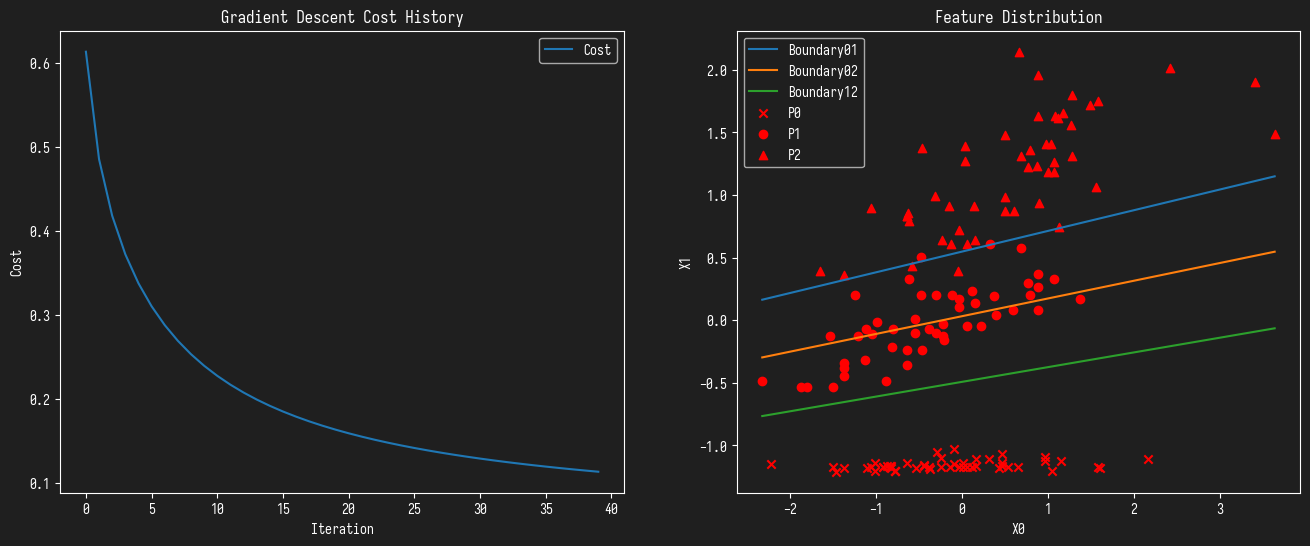

In [6]:
FIGURE = matplotlib.pyplot.figure(figsize=(16, 6))
draw_gradient_descent_cost_history(FIGURE, HISTORY)
draw_feature_distribution(FIGURE, MODEL, X.cpu().detach().numpy(), Y.cpu().detach().numpy())

matplotlib.pyplot.show()

### 数值计算的优化

参考下面的代码，这是因为浮点型运算损失了精度：

In [7]:
print(f"{2 / 10000}:.18f")
print(f"{(1 + 1 / 10000) - (1 - 1 / 10000)}:.18f")

0.0002:.18f
0.00019999999999997797:.18f


所以对于组合函数计算式（如 `sigmoid` ）在 `python` 计算时会出现明显的精度丢失：

$$
\begin{align*}
loss &= -y\log{(\alpha)} - (1 - y)\log{(1 - \alpha)}, \alpha = g(z) = \frac{1}{1 + e^{-z}} \tag{Loss of Precision} \\
loss &= -y\log{(\frac{1}{1 + e^{-z}})} - (1 - y)\log{(1 - \frac{1}{1 + e^{-z}})}
\end{align*}
$$

所以对于 `TensorFlow` 中使用 `SparseCategoricalCrossentropy(from_logits=True)` 可以在数值上提高稳定性，避免精度丢失。

当使用 `torch.nn.CrossEntropyLoss()` 作为损失函数，并且模型的最后一层输出的是 `logits`（未经过 `softmax` 激活函数转换的数值）时，`PyTorch` 会自动在内部处理 `softmax` 和交叉熵的计算，从而实现了数值稳定性，避免了精度丢失。